# Lecture 12 
------------------------
## Intro to Explainable ML

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestRegressor

from sklearn import tree
from graphviz import Source
import graphviz
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from six import StringIO  

from sklearn.inspection import permutation_importance

## Partial dependence plots

In [2]:
from sklearn.datasets import fetch_california_housing

In [3]:
cal_housing = fetch_california_housing()
# print(cal_housing['DESCR'])

In [4]:
data = cal_housing['data']
target = cal_housing['target'].reshape(-1,1) # 1d ro 2d array 
cal_housing_data = np.concatenate((data,target),axis=1)

In [5]:
cal_housing_df = pd.DataFrame(data=cal_housing_data,columns=list(cal_housing['feature_names'])+['MedVal'])
cal_housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [6]:
X = cal_housing_df.drop(['MedVal'],axis=1)
y = cal_housing['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [7]:
#The origial data seem to be scaled to mean 0 and stedev 1, 
#let us put them back on a more "reasonable" sva scale
y_train2 = 750 + y_train*300 

In [8]:
rf_house = RandomForestRegressor(max_depth=50, random_state=0, n_estimators=100,max_features=3)
rf_house.fit(X_train, y_train2)  

RandomForestRegressor(max_depth=50, max_features=3, random_state=0)

Computing partial dependence plots...
done in 1.131s


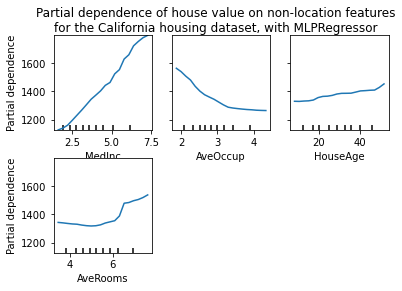

In [9]:
from sklearn.inspection import partial_dependence, plot_partial_dependence
from time import time
print('Computing partial dependence plots...')
tic = time()
features = ['MedInc', 'AveOccup', 'HouseAge', 'AveRooms']
display = plot_partial_dependence(
       rf_house, X_train, features, grid_resolution=20
)
print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    'Partial dependence of house value on non-location features\n'
    'for the California housing dataset, with MLPRegressor'
)
display.figure_.subplots_adjust(hspace=0.3)

**Task**: write your own code producing 20 ICE curves for the feature *AveOccup*

In [10]:
# import copy
# X_train2 = copy.deepcopy(X_train)
# 
# #PDP:
# for avO in np.arange(6):#too coarse, make finer later 
#     X_train2["AveOccup"] = avO
#     pdp[avO] =  np.mean(rf_house.predict(X_train2))
# #ICE:
# for avO in np.arange(6):
#     X_train2["AveOccup"] = avO
#     for j in np.arange(20): #randomize later
#         ice[avO,j] =  rf_house.predict(X_train2.iloc[j,:])#
# 
# 

## SHAP values

### Titanic 

In [11]:
df = pd.read_csv('../data/TitanicTrain.csv') # Load the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [12]:
one_hot_data = pd.get_dummies(df[["Sex", "Pclass", "Age", "PassengerId","Survived"]])
one_hot_data.head()

,Pclass,Age,PassengerId,Survived,Sex_female,Sex_male
0,3,22.0,1,0,0,1
1,1,38.0,2,1,1,0
2,3,26.0,3,1,1,0
3,1,35.0,4,1,1,0
4,3,35.0,5,0,0,1


In [13]:
one_hot_data = one_hot_data[["Sex_male", "Pclass", "Age", "PassengerId","Survived"]].dropna()
X = one_hot_data[['Age', 'Pclass','Sex_male', 'PassengerId']]
y = one_hot_data['Survived']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [14]:
rf = RandomForestRegressor(max_depth=50, random_state=0, n_estimators=100,max_features=2)
rf.fit(X_train, Y_train)  
print(rf.feature_importances_)

[0.25262252 0.13708063 0.29659792 0.31369893]


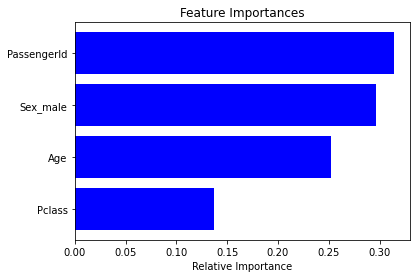

In [15]:
importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [16]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

In [17]:
shap_values.shape

(571, 4)

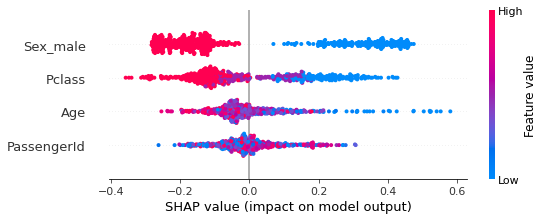

In [18]:
shap.summary_plot(shap_values, X_train)

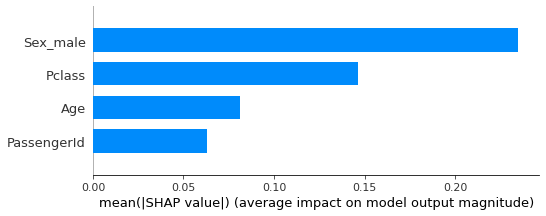

In [19]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted survival prob. as `Age` changes. Vertical dispersion at a single value of age represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring.

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


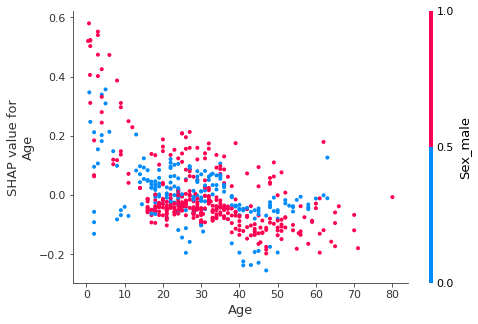

In [20]:
shap.dependence_plot("Age", shap_values=shap_values, features=X_train)

### Force plots

The plot below shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue 

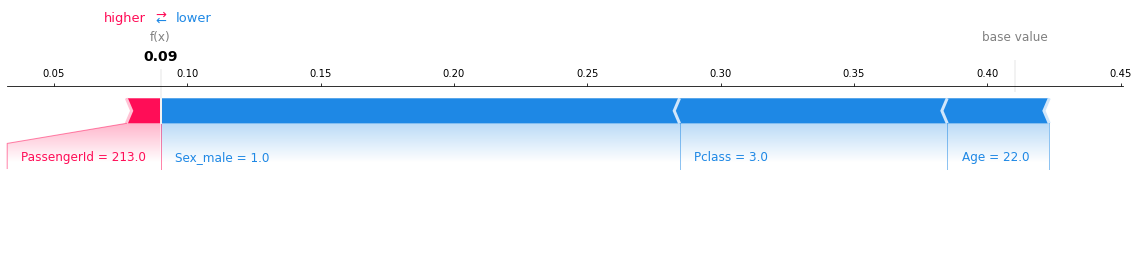

In [21]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# load JS visualization code to notebook
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:],matplotlib=True)

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [22]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train)

### Tasks

1. Visualize SHAP values for the Boston data 
2. Look at interactions